# `sbi` on the classical drift-diffusion model using MNLE

## Motivation

It would be great to do fully Bayesian inference over the parameters of computational models in cognitive neuroscience. However, for many models of interest this is challenging, because Bayesian inference usually requires being able to efficiently evaluate the likelihood of the model, and this is often not possible. For example, when using the drift-diffusion model (DDM) for modeling decision making, only the most basic version of the DDM allows efficent access to the analytical likelihoods, i.e., for most variants Bayesian inference would be challenging. 

Mixed Neural Likelihood Estimation (MNLE) offers a solution to this problem. It enables simulation-based inference (SBI), i.e., Bayesian parameter inference that does not require access to the likelihood, but only access to data simulated from the model. Plus, MNLE is designed for simulation-based models with mixed data types as output, e.g., for models like the DDM, returning categorical choices and continuous reaction times. 

MNLE uses neural networks to parametrize a density estimator, and then trains the neural networks using data simulated from the model, such that the density estimator approximates the (intractable) likelihood of the model. After training, this ``neural likelihood'' can be used to perform Bayesian inference. In other words, given a model over which we want to do inference, but can't because we can't access its likelihood efficiently, we can just MNLE to  learn a synthetic likelihood with which can then do Bayesian inference. 

## SBI on the DDM

In the following we will use the implementation of MNLE and python toolbox [`sbi`](https://github.com/mackelab/sbi) to perform inference on the DDM.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sbi
import torch

import sbibm

# Plotting settings
plt.style.use('plotting_settings.mplstyle')
# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

## The DDM

We implemented an efficient version of the DDM as part of the benchmarking framework [`sbibm`](https://github.com/sbi-benchmark) and will use it here for generating training data for MNLE.

In this implementation the DDM has four parameters, the drift $v$, the decision boundary separation $a$, the initial offset/bias $w$, and the non-decision time $\tau$,  

In SBI we usually call parameters `theta` and simulated data `x`. The data that is observed experimentally is called `x_o`. 

Our goal is to obtain the posterior over parameters, given observed data, $p(\theta | x_o)$. To do this we generate training data $(\theta, x)$ to learn a neural likelihood with MNLE. 

In [2]:
# Loading DDM simulator and prior from sbibm framework.
task = sbibm.get_task("ddm")
prior = task.get_prior_dist()
simulator = task.get_simulator()

In [3]:
# Load training data from disk.
N = 100000

with open("../data/ddm_training_data.p", "rb") as fh:
    theta, x1d, tho, xos = pickle.load(fh).values()
    # choices are encoded in the sign of the reaction times.
    # decode and put them in separate columns.
    x = torch.zeros(x1d.shape[0], 2)
    x[:, 0] = abs(x1d.squeeze())
    x[x1d.squeeze()>0, 1] = 1

theta = theta[:N]
x = x[:N]

For the DDM we can visualize the choice and reaction time data in one dimension by encoding the binary choice as the sign of the reaction time:

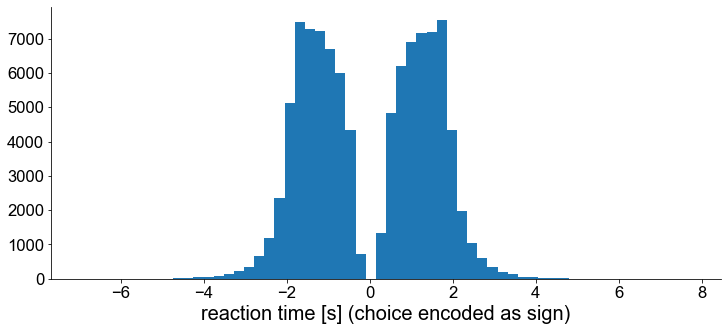

In [4]:
plt.figure(figsize=(12, 5))
plt.hist(x1d.numpy(), bins=60)
plt.xlabel("reaction time [s] (choice encoded as sign)");

## MNLE with `sbi`

To be applicable to models with mixed data types, MNLE actually learns two neural density estimators, one for the discrete part of the data (e.g., choices), and one for the continuous part (e.g., reation times). To choice density estimator estimates the density over choices given parameters. Crucially, to also learn the statistical dependencies between choices and reaction times, the reation time density estimator learns the density over reation times given parameters *and* choices. 

We have integreated `MNLE` into the `sbi` toolbox such that training and inference is straight forward:

In [5]:
# Required import from sbi.
from sbi.analysis import pairplot
from sbi.inference import MNLE
from sbi.inference import MCMCPosterior
from sbi.utils.metrics import c2st

## Training
Using `sbi` we just create an `MNLE` object, append the training data (`x` contains both continuous and discrete data, `sbi` takes care of handling them internally), and call `.train()` to optimize the parameters of the underlying neural nets.

In [6]:
trainer = MNLE(prior=prior)
trainer = trainer.append_simulations(theta, x)
mnle = trainer.train()

/home/janfb/qode/sbi/sbi/neural_nets/mnle.py:40: UserWarning: The mixed neural likelihood estimator assumes that x contains
                  continuous data in the first n-1 columns (e.g., reation times) and
                  categorical data in the last column (e.g., corresponding choices). If
                  this is not the case for the passed `x` do not use this function.
  this is not the case for the passed `x` do not use this function."""


 Training neural network. Epochs trained:  66Neural network successfully converged after 66 epochs.


### Testing MNLE

We can test MNLE simply by generating synthetic data from it: Because it performs conditional density estimation, we can `sample()` the MNLE object given parameters, to generate synthetic DDM data:

In [7]:
M = 10000
x_syn = mnle.sample(tho, M)
# To be able to plot the data in 1D we again encode choices as sign.
x_syn_1d = x_syn[:, :1]
# Set reaction times negative for zero-choices.
x_syn_1d[x_syn[:, 1:]==0, ] *= -1

Comparing the synthetic data to the corresponding data generated from the original DDM simulator we see that MNLE accurately emulates the DDM. This indicates, that it successfully learned the underlying likelihood!

Additionally, we can obtain the likelihoods of the reaction time and choices, given the underlying parameter, by calling `.log_prob()`.

In [8]:
# Construct test reaction times.
test_data = torch.linspace(-8, 8, 1000)
# Separate rts and choices.
test_rts = abs(test_data)
test_cs = torch.ones_like(test_data)
test_cs[test_data < 0] = 0
test_x = torch.stack((test_rts, test_cs), dim=1)

# Get the log likelihood of the entire range of reaction times and choices.
mnle_likelihoods = mnle.log_prob(test_x, tho.repeat(1000, 1)).detach()

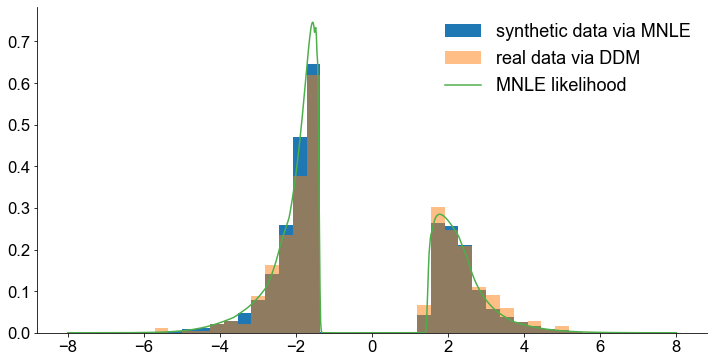

In [9]:
# Plot the real simulated data, the synthetic data, and the learned synthetic likelihoods.
plt.figure(figsize=(12, 6))
density = True
_, bins, _ = plt.hist(x_syn_1d.numpy(), bins="auto", color="C0", 
                      label="synthetic data via MNLE", density=density);
# Plot real data on top,
plt.hist(xos.numpy(), bins=bins, alpha=0.5, color="C1", label="real data via DDM", density=density)
# and the MNLE likelihoods
plt.plot(test_data, mnle_likelihoods.exp(), label="MNLE likelihood", ls="-", c=colors[2]);
plt.legend();

## Infer posterior samples with MCMC

In [10]:
# Observations from the benchmark come in 1D and encode choice with sign.
# This observation index corresponds to an observation with 10 trials.
obs = 102
xo_signed = task.get_observation(obs)
x_o = torch.zeros(xo_signed.shape[1], 2)
theta_o = task.get_true_parameters(obs)
# Bring x into the form [rt, c]
x_o[:, 0] = abs(xo_signed[0, :])
x_o[(xo_signed > 0)[0, :], 1] = 1
print(f"x-shape: {x_o.shape}")

x-shape: torch.Size([10, 2])


In [11]:
# Using the trainer object we can obtain the posterior object with the desired MCMC options for inference.
posterior = trainer.build_posterior(mcmc_method="slice_np_vectorized", 
                                    mcmc_parameters=dict(init_strategy="sir", 
                                                         num_chains=10, 
                                                         warmup_steps=100))

In [12]:
# and infer posterior samples given the observed data x_o.
posterior_samples = posterior.sample((1000,), x=x_o)

/home/janfb/qode/sbi/sbi/utils/sbiutils.py:282: UserWarning: An x with a batch size of 10 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  respect to entire batch, i.e,. p(theta | X)."""
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [06:20<00:00, 52.57it/s]


In [13]:
# Calculate c2st score between reference posterior and approximate posterior samples.
reference_posterior_samples = task.get_reference_posterior_samples(obs)[:1000]
print(f"c2st-score: {c2st(posterior_samples, reference_posterior_samples)}")

c2st-score: tensor([0.5375])


## Visualize posteriors

To visualize the 4-D posterior we use a corner plot showing the 1-D marginals on the diagonal and all 2-D marginals  on the off-diagonal. The densities are estimated from MCMC samples with KDE. 

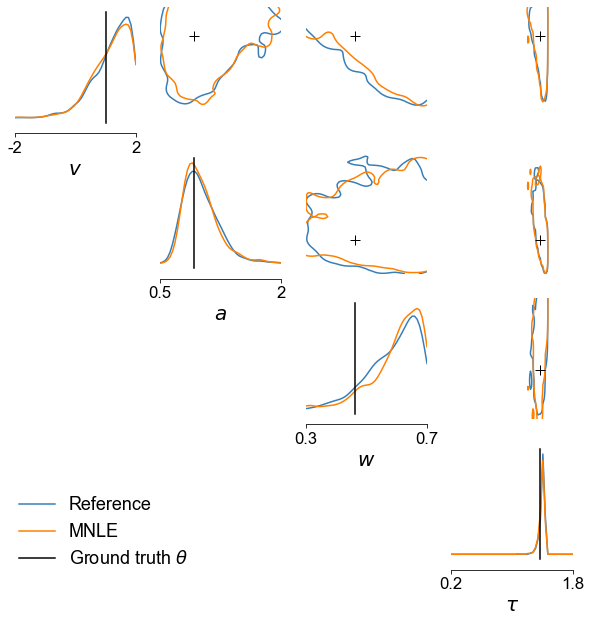

In [14]:
limits = [[-2, 2], [0.5, 2.0], [.3, .7], [.2, 1.8]]

fig, ax1 = pairplot([reference_posterior_samples, posterior_samples],
         points=sbibm.get_task("ddm").get_true_parameters(obs), 
         limits=limits, 
         ticks=limits, 
         samples_colors=colors[:2], 
         diag="kde",
         upper="contour",
         kde_offdiag=dict(bw_method="scott", bins=50),
         contour_offdiag=dict(levels=[0.01], percentile=False),
         points_offdiag=dict(marker="+", markersize=10), 
         points_colors=["k"], 
         labels=[r"$v$", r"$a$", r"$w$", r"$\tau$"])

plt.sca(ax1[0, 0])
plt.legend(["Reference", "MNLE", r"Ground truth $\theta$"], 
           bbox_to_anchor=(-.1, -2.9), 
           loc=2);

We see that the inferred posterior accurately matches the ground-truth reference posterior.

## Repeat inference with different observed data, without re-training MNLE

MNLE is trained on data from the entire prior space, thus we can re-use the neural nets for new `x` without having the re-train `MNLE`. This works even if `x` has different number of trials. Here we repeat the inference with a different `x` which contains reation times and choices from 100 trials.

In [15]:
# Observations from the benchmark come in 1D and encode choice with sign.
# observation idx corresponding to 100 trials.
obs = 202
xo_signed = task.get_observation(obs)
x_o = torch.zeros(xo_signed.shape[1], 2)
theta_o = task.get_true_parameters(obs)
# Bring x into the form [rt, c]
x_o[:, 0] = abs(xo_signed[0, :])
x_o[(xo_signed > 0)[0, :], 1] = 1
print(f"x-shape: {x_o.shape}")

x-shape: torch.Size([100, 2])


In [22]:
# Infer with MCMC
posterior_samples = posterior.sample((1000,), x=x_o, )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [18:12<00:00, 18.30it/s]


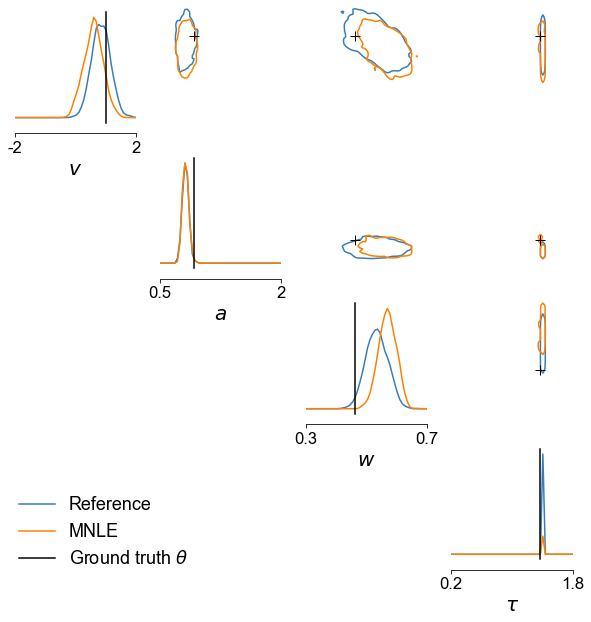

In [23]:
reference_posterior_samples = task.get_reference_posterior_samples(obs)[:1000]

fig, ax1 = pairplot([reference_posterior_samples, posterior_samples],
         points=sbibm.get_task("ddm").get_true_parameters(obs), 
         limits=limits, 
         ticks=limits, 
         samples_colors=colors[:2], 
         diag="kde",
         upper="contour",
         kde_offdiag=dict(bw_method="scott", bins=50),
         contour_offdiag=dict(levels=[0.01], percentile=False),
         points_offdiag=dict(marker="+", markersize=10), 
         points_colors=["k"], 
         labels=[r"$v$", r"$a$", r"$w$", r"$\tau$"])

plt.sca(ax1[0, 0])
plt.legend(["Reference", "MNLE", r"Ground truth $\theta$"], 
           bbox_to_anchor=(-.1, -2.9), 
           loc=2);

In [24]:
# Calculate c2st score between reference posterior and approximate posterior samples.
print(f"c2st-score: {c2st(posterior_samples, reference_posterior_samples)}")

c2st-score: tensor([0.7845])
